# Global Temperature Change Analysis
We analize the annual global mean temperature anomalies provided by the [Goddard Institute for Space Studies (GISS)](https://data.giss.nasa.gov/gistemp/). The [dataset](https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv) is available for download as CSV file from the GISS website. This notebook follows an example from ch.4 of the book ["Time Series Forecasting in Python"](https://www.manning.com/books/time-series-forecasting-in-python-book) by M. Peixeiro, but uses a different dataset.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import dates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from osgeo import gdal, osr, ogr
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("Python version: %s"%python_version())
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print('GDAL version: %s'%gdal.__version__)
print("GeoPandas version: %s"%gpd.__version__)

Python version: 3.11.5
NumPy version: 1.25.2
Pandas version: 2.1.1
GDAL version: 3.7.2
GeoPandas version: 0.14.0


## The dataset
We download the dataset from the GISS website

In [2]:
url = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
ds_path = 'data/GLB.Ts+dSST.csv'
giss_temp = pd.read_csv(ds_path, header=1)
giss_temp.tail(2)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
142,2022,0.91,0.89,1.05,0.84,0.84,0.92,0.94,0.95,0.89,0.96,0.72,0.80,0.89,.90,.89,0.91,0.94,0.86
143,2023,0.87,0.98,1.20,1.00,0.94,1.08,1.19,1.19,1.48,1.34,1.43,1.37,1.17,1.12,.88,1.05,1.15,1.41


In [3]:
year_index = pd.date_range('1880', '2024', freq='Y')
giss_temp.set_index(year_index, inplace=True)
giss_temp.drop('Year', axis=1, inplace=True)
giss_temp.head(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
1880-12-31,-0.19,-0.24,-0.09,-0.16,-0.10,-0.21,-0.18,-0.10,-0.14,-0.23,-0.21,-0.18,-0.17,***,***,-0.12,-0.16,-0.19
1881-12-31,-0.20,-0.14,0.03,0.05,0.06,-0.19,0.00,-0.04,-0.15,-0.22,-0.19,-0.07,-0.09,-.10,-.17,0.05,-0.08,-0.19


We compute the annual means from the mean temperature anomalies of each month.  

In [4]:
annual_mean = []
for index, row in giss_temp.iterrows():
    sum = 0
    months = 0
    for col in giss_temp.columns[0:12]:
        sum += row[col]  
    annual_mean.append(round(sum / 12, 2))

We add the annual mean to the dataset

In [5]:
giss_temp['Annual Mean'] = annual_mean
giss_temp.tail(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON,Annual Mean
2022-12-31,0.91,0.89,1.05,0.84,0.84,0.92,0.94,0.95,0.89,0.96,0.72,0.80,0.89,.90,.89,0.91,0.94,0.86,0.89
2023-12-31,0.87,0.98,1.20,1.00,0.94,1.08,1.19,1.19,1.48,1.34,1.43,1.37,1.17,1.12,.88,1.05,1.15,1.41,1.17


## Uncertainty
The uncertainty is provided in an additional [file](https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/totalCI_ERA.csv) available from the [GISS](https://data.giss.nasa.gov/gistemp/graphs_v4/) website

In [6]:
url_error_data = 'https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/totalCI_ERA.csv'
error_ds_path = 'data/totalCI_ERA.csv'
error_data = pd.read_csv(error_ds_path)
error_data['ci95'].astype(float)
error = error_data['ci95']
error_data['ci95'] = error.apply(lambda error: round(error, 2)) 
error_data.tail(2)

,year,ci95
142,2022,0.05
143,2023,0.05


In [7]:
num_years = len(giss_temp)
print('Number of years of recorded anomalies: {0:d}'.format(num_years))

Number of years of recorded anomalies: 144


In [8]:
giss_temp['Uncertainty'] = error_data['ci95'].tolist()
giss_temp['Uncertainty']
giss_temp.tail(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON,Annual Mean,Uncertainty
2022-12-31,0.91,0.89,1.05,0.84,0.84,0.92,0.94,0.95,0.89,0.96,0.72,0.80,0.89,.90,.89,0.91,0.94,0.86,0.89,0.05
2023-12-31,0.87,0.98,1.20,1.00,0.94,1.08,1.19,1.19,1.48,1.34,1.43,1.37,1.17,1.12,.88,1.05,1.15,1.41,1.17,0.05


We plot the data of the global mean temperature anomalies from 1880 to 2023 with the error bars

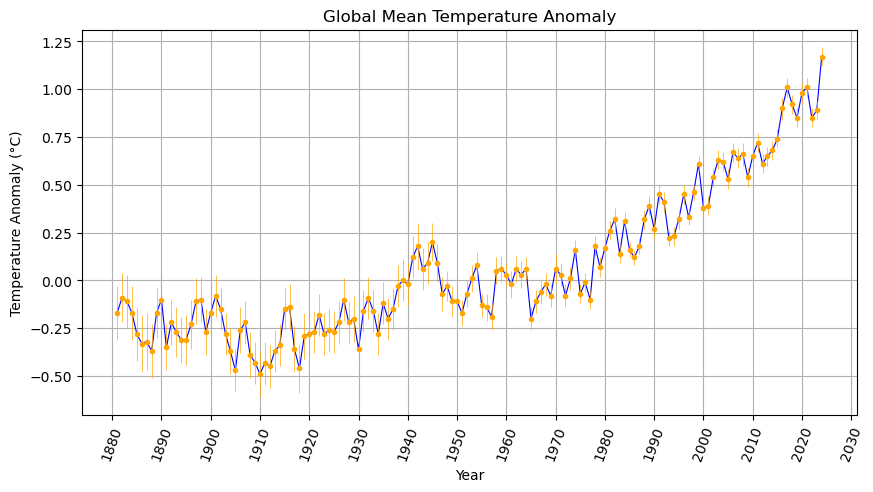

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Global Mean Temperature Anomaly')
ax.set_ylabel('Temperature Anomaly (°C)')
ax.set_xlabel('Year')
ax.set_xticks(giss_temp.index)
ax.set_xticklabels(giss_temp.index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_giss_temp = ax.plot(giss_temp['Annual Mean'], linewidth=0.8, label='temp.anom', color='blue')
plt_giss_error= ax.errorbar(giss_temp.index, giss_temp['Annual Mean'], yerr=giss_temp['Uncertainty'], linewidth=0.5, color='orange', fmt='.k');
#plt.legend(loc='upper left')
plt.savefig('giss_anomaly.png', dpi=300)

## Models
We test different models of the process that can represent the temperature anomalies. We start with a simple random walk process and after that we test a moving average model.  

### Random walk
The random walk is a process for which the value of a variable y at time t, $y_t$, depends on its value at time t-1, $y_{t-1}$, a constant value $\delta$, and on a random component $\epsilon$

$$y_t = y_{t-1} + \delta + \epsilon$$

Using this model we assume that the value of a variable y is the result of a cumulative sum of random values sampled from a distribution, for example a gaussian distribution. 

$$y_t = \sum_{i=1}^{t-1} \epsilon_i$$

If we assume for simplicity that $\delta = 0$, we can see that

$$y_t - y_{t-1} = \epsilon$$

that is the difference between two values is only a random value. This result means that the statistical properties, i.e. mean value, standard deviation, and autocorrelation of the difference don't change or are stationary. The randowm walk model, the moving average model (MA), the autoregressive model (AR) and the autoregressive moving average model (ARMA) are all stationary. 

### Stationarity
We test the dataset for stationarity. We already know from the plot that the process is not stationary but there is a test that can be used to verify the stationarity of a time-series called [Augmented Dickey-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) or ADF. The ADF test searches for a unit root ($\alpha = 1$) of the equation

$$y_t - \alpha y_{t-1} = \delta + \epsilon$$

If $\alpha$ is indeed unitary the time-series is not stationary. if $-1<\alpha<1$ the time series is stationary. The ADF test returns also a p-value. If p = 0.05 or less we can be confident of the result at 95% or more. For example if $\alpha$ = 0.5 and p = 0.01, then the process is stationary, if $\alpha$ = 1.0 and p = 0.05 then the process is nonstationary.

### Standard deviation
The standard deviation of the process, in case it is a random walk, should be constant and equal to the standard deviation of the $\epsilon$ component.

### Autocorrelation
We said that a stationary process must have a constant mean value, standard deviation and autocorrelation. We can test for the autocorrelation between two values with a unitary lag, i.e. $y_t$ and $y_{t-1}$, or a lag of 2, e.g. $y_t$ and $y_{t-2}$, or more.

### ADF test
The ADF test for the global temperature anomalies returns a value greater thann 1 and with a p-value greater than 0.05 so we cannot reject the null hypothesis that the process is not stationary. 

In [10]:
ADF_result = adfuller(giss_temp['Annual Mean'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 1.4641340696516245
p-value: 0.9973868775709003


### First-order difference
We compute the first-order difference of the global temperature anomalies time series. The difference removes the trend and might be stationary

In [11]:
giss_temp_diff = np.diff(giss_temp['Annual Mean'], n=1)
giss_temp_diff_df = pd.DataFrame({'Diff': giss_temp_diff}, index=year_index[1:])

In [12]:
giss_temp_diff.size

143

When we plot the first-order difference time-series we can see that it looks stationary with the values randomly distributed around a 0 mean value. 

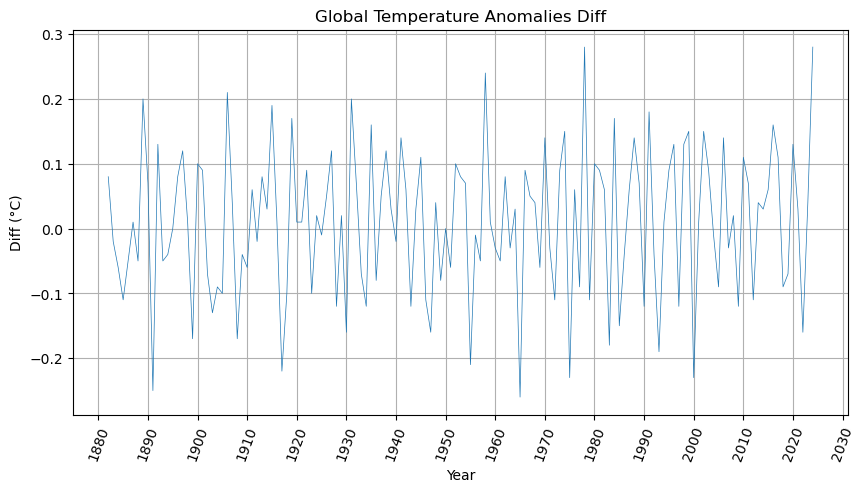

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Global Temperature Anomalies Diff')
ax.set_ylabel('Diff (°C)')
ax.set_xlabel('Year')
ax.set_xticks(giss_temp_diff_df.index)
ax.set_xticklabels(giss_temp_diff_df.index, rotation=70)
ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_google_diff = ax.plot(giss_temp_diff_df, linewidth=0.5, label='anom.diff')
#plt.legend(loc='upper left')

Nonetheless we apply the ADF test to the first-order difference to assess whether it is stationary. Since the output is lower than -1 and the p-value is lower than 0.05 we can reject the null hypothesis that the difference time series is not stationary. 

In [14]:
ADF_result = adfuller(giss_temp_diff_df)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -7.562154289780749
p-value: 2.990356395695225e-11


Now we test for the autocorrelation of the first-order difference. We can see in the autocorrelation plot that there are two consecutive lag values, lag = 1 and lag = 2 with the autocorrelation that look somewhat significant. In this case a random walk model is not appropriate to represent the time-series

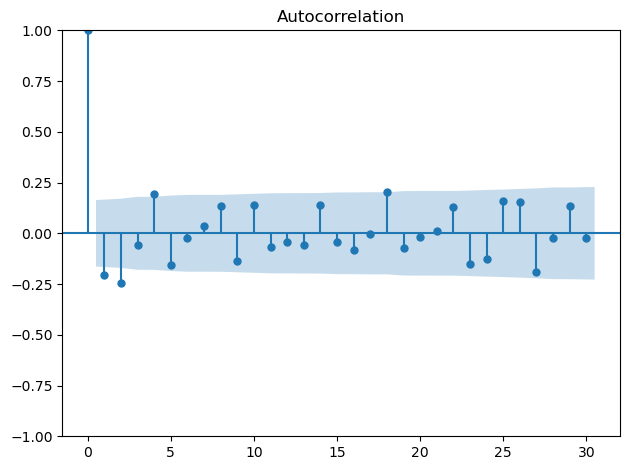

In [15]:
plot_acf(giss_temp_diff_df, lags=30)
plt.tight_layout()

### Moving Average (MA)
We want to see whether another model, the moving average model, can better represent the first-order difference time-series. In a moving average model of order q, MA(q), the value of a variable at time $y_t$ depends on a linear combination of the mean value of the time-series $\mu$ the present error term $\epsilon_t$ and the q previous error terms

$$y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + .. + \theta_q \epsilon_{t-q}$$

The same expression for a moving average model of order 1 is

$$y_t = \mu + \epsilon_t + \theta_1\epsilon_{t-1}$$

We have seen that the first-order difference temperature anomalies has the coefficients of lag 1 and 2 so we can test whether the moving average model of order 2, MA(2), can represent it.

## Forecasts
We set up three models to forecast the global temperature anomalies. The "mean" model will simply forecast the mean value of the time-series, while the "last" model will forecast the last value. These two model will be used as a baseline to assess the performance of the MA(2) model. We split the 143 annual records into a test set of 128 records (90%) and a test set of 15 records.    

In [16]:
train = giss_temp_diff_df[:int(0.9*len(giss_temp_diff_df))]
test = giss_temp_diff_df[int(0.9*len(giss_temp_diff_df)):]
print('Training dataset size: {0:d}\nTest dataset size: {1:d}'.format(len(train), len(test)))

Training dataset size: 128
Test dataset size: 15


We define a function that takes as input the train dataset, the method name, and the horizon, that is the time window of the forecast that has the same size as the test set, and outputs the predictions as a list. 

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,window))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA

We plot the global temperature anomalies and the first-order difference time-series highlighting the time horizon used to test the performance of the MA(2) model against the baselines.

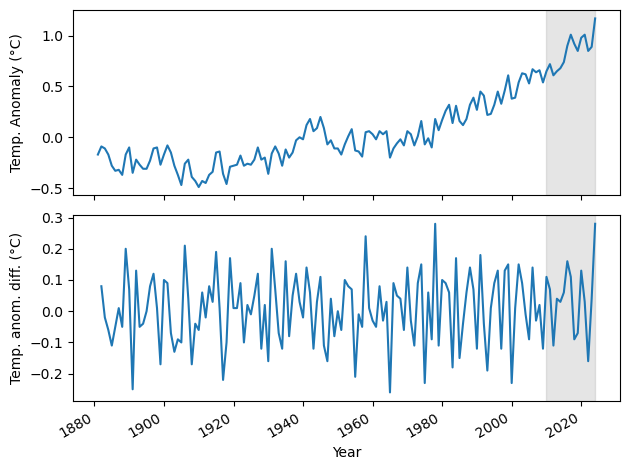

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.plot(giss_temp['Annual Mean'])
ax1.set_xlabel('Year')
ax1.set_ylabel('Temp. Anomaly (°C)')
ax1.axvspan('2009-12-31', '2023-12-31', color='#808080', alpha=0.2)

ax2.plot(giss_temp_diff_df['Diff'])
ax2.set_xlabel('Year')
ax2.set_ylabel('Temp. anom. diff. (°C)')
ax2.axvspan('2009-12-31', '2023-12-31', color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

In [19]:
pred_df = test.copy()
len(pred_df)

15

In [20]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2
print('Train: {0:d}\nHorizon: {1:d}'.format(TRAIN_LEN, HORIZON))

Train: 128
Horizon: 15


In [21]:
pred_mean = rolling_forecast(giss_temp_diff_df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(giss_temp_diff_df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(giss_temp_diff_df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

In [22]:
len(pred_MA)

16

In [23]:
pred_df['pred_mean'] = pred_mean[:HORIZON]
pred_df['pred_last_value'] = pred_last_value[:HORIZON]
pred_df['pred_MA'] = pred_MA[:HORIZON]
pred_df

,Diff,pred_mean,pred_last_value,pred_MA
2009-12-31,0.11,0.005547,-0.12,0.024366
2010-12-31,0.07,0.005547,-0.12,0.020325
2011-12-31,-0.11,0.006846,0.07,-0.047628
2012-12-31,0.04,0.006846,0.07,-0.016812
2013-12-31,0.03,0.006212,0.04,0.000195
2014-12-31,0.06,0.006212,0.04,-0.006958
2015-12-31,0.16,0.006791,0.06,-0.034961
2016-12-31,0.11,0.006791,0.06,-0.016003
2017-12-31,-0.09,0.008676,0.11,-0.103418
2018-12-31,-0.07,0.008676,0.11,-0.039158


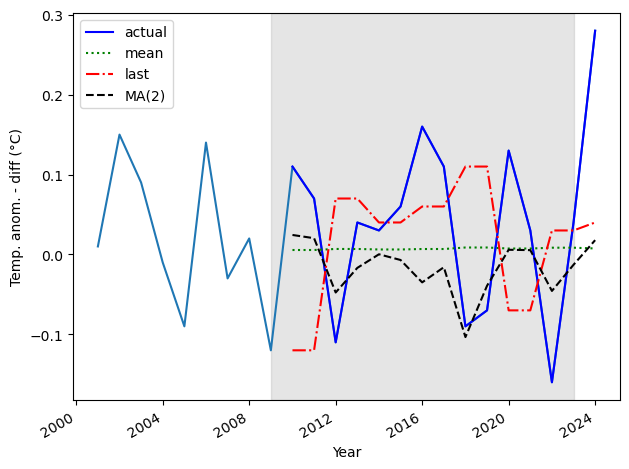

In [24]:
fig, ax = plt.subplots()
ax.plot(giss_temp_diff_df['Diff']['2000':])
ax.plot(pred_df['Diff']['2000':], 'b-', label='actual')
ax.plot(pred_df['pred_mean']['2000':], 'g:', label='mean')
ax.plot(pred_df['pred_last_value']['2000':], 'r-.', label='last')
ax.plot(pred_df['pred_MA']['2000':], 'k--', label='MA(2)')
ax.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Temp. anom. - diff (°C)')
ax.axvspan('2009', '2023', color='#808080', alpha=0.2)
fig.autofmt_xdate()
plt.tight_layout()

We compute the mean squared error (MSE) for the three models. The MA(2) model is slightly better than the other two baseline models.

In [25]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['Diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['Diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['Diff'], pred_df['pred_MA'])

print('MSE mean: {0:.3f}\nMSE last: {1:.3f}\nMSE MA(2): {2:.3f}'.format(mse_mean, mse_last, mse_MA))

MSE mean: 0.014
MSE last: 0.023
MSE MA(2): 0.012


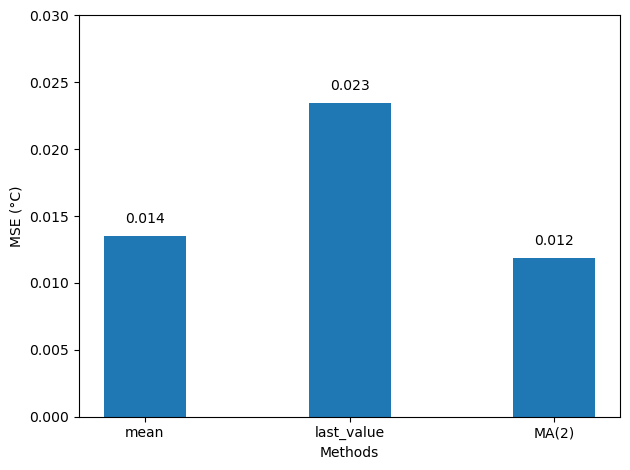

In [31]:
fig, ax = plt.subplots()
x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE (°C)')
ax.set_ylim(0, 0.03)
for index, value in enumerate(y):
    plt.text(x=index, y = value + 0.001, s=str(round(value, 3)), ha='center')
plt.tight_layout()

We have to invserse-transform the predictions for first-order difference of the MA(2) model to get the predictions for the global temperature anomalies.

In [120]:
giss_temp['Prediction'] = pd.Series()
giss_temp['Prediction']['2009':] = giss_temp['Annual Mean']['2009':] + pred_df['pred_MA'].cumsum()
#giss_temp['Prediction']['2009':] = giss_temp['Annual Mean']['2009':] + pred_df['pred_mean'].cumsum()
giss_temp['Prediction']['2009':]

2009-12-31    0.674366
2010-12-31    0.764691
2011-12-31    0.607063
2012-12-31    0.630252
2013-12-31    0.660446
2014-12-31    0.713488
2015-12-31    0.838528
2016-12-31    0.932525
2017-12-31    0.739107
2018-12-31    0.629949
2019-12-31    0.765788
2020-12-31     0.80117
2021-12-31    0.595498
2022-12-31    0.622582
2023-12-31    0.920457
Freq: A-DEC, Name: Prediction, dtype: object

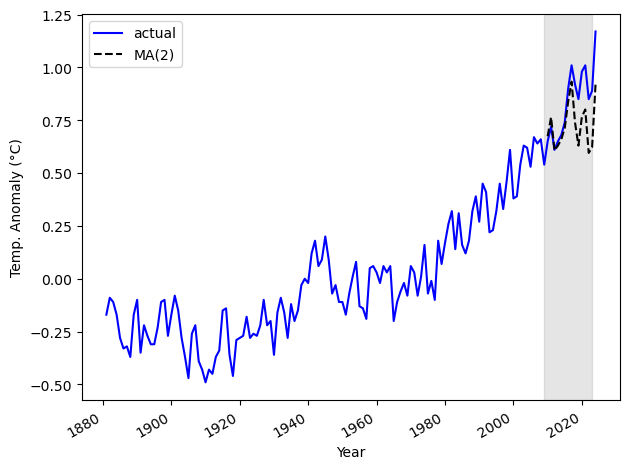

In [121]:
fig, ax = plt.subplots()
ax.plot(giss_temp['Annual Mean'], 'b-', label='actual')
ax.plot(giss_temp['Prediction'], 'k--', label='MA(2)')
ax.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Temp. Anomaly (°C)')
ax.axvspan('2009', '2023', color='#808080', alpha=0.2)
fig.autofmt_xdate()
plt.tight_layout()

Finally, we compute the mean absolute error for the predictions of the global annual mean temperature anomalies made using the MA(2) model.

In [124]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(giss_temp['Annual Mean']['2009':], giss_temp['Prediction']['2009':])
print('MSE for the predicitons of the Global Annuall Mean Temperature Anomalies: {0:.3f} °C'.format(mae_MA_undiff))

MSE for the predicitons of the Global Annuall Mean Temperature Anomalies: 0.125 °C
